In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import os
import re
import scipy.stats as ss
import scikit_posthocs as sp
from scipy import signal
from matplotlib.dates import date2num
from matplotlib.collections import LineCollection
plt.rcParams['pdf.fonttype'] = 42

In [2]:
window = 3 # 移動平均の範囲
w = np.ones(window)/window

dirs = glob.glob("./2023*")
df_all = pd.DataFrame({})
df_stats = pd.DataFrame({})
for dir_name in dirs:
    if dir_name[-1] == "d":
        # xxx_not-used のディレクトリを省く
        continue
    csvs = glob.glob(dir_name + "/_analysis/_results*.csv")
    phos = dir_name[11:-18]
    for csv in csvs:
        df_read = pd.read_csv(csv)
        stage_num = csv[-5]
        cells = df_read[" Lineage"].unique().tolist()  # cell idを抜き出す
        for cell in cells:
            if "_" not in cell:
                continue
            if "_1_1" in cell:
                continue
                
            df_cell = df_read.loc[df_read[" Lineage"] == cell]
            if len(df_cell) <20:
                continue
            df_FRET = df_cell[" AverageBrightness(Seg)_C0"]
            df_CFP = df_cell[" AverageBrightness(Seg)_C1"]
            df_ratio = df_FRET / df_CFP
            df_ratio_sm = np.convolve(df_ratio, w, mode='valid')

            time = [i*5 for i in range(len(df_FRET))]
            time_end = [(i-len(time)+1)*5 for i in range(len(df_FRET))]
            ID = [phos+"-"+stage_num+"-"+cell for i in range(len(df_FRET))]
            phos_list = [phos for i in range(len(df_FRET))]
            stage_list = [stage_num for i in range(len(df_FRET))]
            
            cc_len = time[-1]
            peak_top = max(df_ratio)

            temp = pd.DataFrame([time, time_end, df_ratio, df_ratio_sm, ID, phos_list], index=["time", "time-end", "ratio", "ratio_sm", "cell ID", "phosphatases"])
            df_all = pd.concat([df_all, temp.T], ignore_index=True)

            temp = pd.DataFrame([cc_len, peak_top, phos], index=["duration", "max", "phosphatases"])
            df_stats = pd.concat([df_stats, temp.T], ignore_index=True)

display(df_all)
df_all.to_csv("./_df_all.csv")

display(df_stats)
df_all.to_csv("./_df_stats.csv")

time time-end     ratio  ratio_sm          cell ID phosphatases
0       0     -195  1.552053   1.56072   pph3-1-[ 1_1 ]         pph3
1       5     -190  1.518187  1.591589   pph3-1-[ 1_1 ]         pph3
2      10     -185  1.611921  1.634225   pph3-1-[ 1_1 ]         pph3
3      15     -180  1.644659  1.638327   pph3-1-[ 1_1 ]         pph3
4      20     -175  1.646093  1.622356   pph3-1-[ 1_1 ]         pph3
...   ...      ...       ...       ...              ...          ...
6687  225      -20  2.022186  1.985038  dis2-2-[ 13_1 ]         dis2
6688  230      -15  1.990524  1.879684  dis2-2-[ 13_1 ]         dis2
6689  235      -10  1.942405  1.745493  dis2-2-[ 13_1 ]         dis2
6690  240       -5  1.706122      None  dis2-2-[ 13_1 ]         dis2
6691  245        0  1.587953      None  dis2-2-[ 13_1 ]         dis2

[6692 rows x 6 columns]

duration       max phosphatases
0        195   2.00564         pph3
1        205   2.03295         pph3
2        190   2.15034         pph3
3        230  2.172538         pph3
4        175  2.011045         pph3
..       ...       ...          ...
144      165  2.037599         dis2
145      170  2.034574         dis2
146      295  2.177235         dis2
147      130  2.038678         dis2
148      245  2.053816         dis2

[149 rows x 3 columns]

In [3]:
phos = df_stats["phosphatases"].unique().tolist()  # phosphatasesを抜き出す
arr_duration = [df_stats.loc[df_stats["phosphatases"] == i]["duration"].values for i in phos]
H, p = ss.kruskal(*arr_duration)
print(p)

2.142236874140268e-05


In [4]:
# Conover検定よるpost-hoc解析
Conover = sp.posthoc_conover(df_stats,val_col='duration', group_col='phosphatases')
Conover

Par2     Sds21     clp1d      dis2          pab1      par1  \
Par2   1.000000e+00  0.368193  0.186787  0.116247  3.005572e-07  0.038737   
Sds21  3.681933e-01  1.000000  0.592665  0.392108  2.213837e-06  0.167747   
clp1d  1.867867e-01  0.592665  1.000000  0.737334  7.429972e-05  0.418071   
dis2   1.162468e-01  0.392108  0.737334  1.000000  6.050339e-04  0.659845   
pab1   3.005572e-07  0.000002  0.000074  0.000605  1.000000e+00  0.002118   
par1   3.873707e-02  0.167747  0.418071  0.659845  2.117622e-03  1.000000   
ppa1   5.870631e-01  0.783661  0.466436  0.312995  7.739559e-06  0.139451   
ppa2   5.334005e-03  0.031133  0.128531  0.270178  1.322575e-02  0.502050   
ppe1   8.914665e-01  0.286582  0.139529  0.085449  1.067507e-07  0.025971   
pph3   2.882771e-01  0.787998  0.813845  0.581622  4.017091e-05  0.307086   
wt     8.583410e-01  0.504663  0.275045  0.176942  1.656090e-06  0.068114   

           ppa1      ppa2          ppe1      pph3        wt  
Par2   0.587063  0.005334  8.914665e-01  0.288277  0.858341  
Sds21  0.783661  0.031133  2.865818e-01  0.787998  0.504663  
clp1d  0.466436  0.128531  1.395286e-01  0.813845  0.275045  
dis2   0.312995  0.270178  8.544893e-02  0.581622  0.176942  
pab1   0.000008  0.013226  1.067507e-07  0.000040  0.000002  
par1   0.139451  0.502050  2.597119e-02  0.307086  0.068114  
ppa1   1.000000  0.030287  4.950524e-01  0.624419  0.725184  
ppa2   0.030287  1.000000  3.091267e-03  0.085293  0.011925  
ppe1   0.495052  0.003091  1.000000e+00  0.225450  0.754904  
pph3   0.624419  0.085293  2.254502e-01  1.000000  0.396836  
wt     0.725184  0.011925  7.549043e-01  0.396836  1.000000

In [6]:
# Conover検定よるpost-hoc解析
Conover = sp.posthoc_conover(df_stats,val_col='duration', group_col='phosphatases', p_adjust="holm")
Conover

Par2     Sds21     clp1d      dis2      pab1      par1      ppa1  \
Par2   1.000000  1.000000  1.000000  1.000000  0.000016  1.000000  1.000000   
Sds21  1.000000  1.000000  1.000000  1.000000  0.000115  1.000000  1.000000   
clp1d  1.000000  1.000000  1.000000  1.000000  0.003641  1.000000  1.000000   
dis2   1.000000  1.000000  1.000000  1.000000  0.029042  1.000000  1.000000   
pab1   0.000016  0.000115  0.003641  0.029042  1.000000  0.099528  0.000395   
par1   1.000000  1.000000  1.000000  1.000000  0.099528  1.000000  1.000000   
ppa1   1.000000  1.000000  1.000000  1.000000  0.000395  1.000000  1.000000   
ppa2   0.240030  1.000000  1.000000  1.000000  0.568707  1.000000  1.000000   
ppe1   1.000000  1.000000  1.000000  1.000000  0.000006  1.000000  1.000000   
pph3   1.000000  1.000000  1.000000  1.000000  0.002009  1.000000  1.000000   
wt     1.000000  1.000000  1.000000  1.000000  0.000088  1.000000  1.000000   

           ppa2      ppe1      pph3        wt  
Par2   0.240030  1.000000  1.000000  1.000000  
Sds21  1.000000  1.000000  1.000000  1.000000  
clp1d  1.000000  1.000000  1.000000  1.000000  
dis2   1.000000  1.000000  1.000000  1.000000  
pab1   0.568707  0.000006  0.002009  0.000088  
par1   1.000000  1.000000  1.000000  1.000000  
ppa1   1.000000  1.000000  1.000000  1.000000  
ppa2   1.000000  0.142198  1.000000  0.524718  
ppe1   0.142198  1.000000  1.000000  1.000000  
pph3   1.000000  1.000000  1.000000  1.000000  
wt     0.524718  1.000000  1.000000  1.000000

In [9]:
phos = df_stats["phosphatases"].unique().tolist()  # phosphatasesを抜き出す
arr_duration = [df_stats.loc[df_stats["phosphatases"] == i]["max"].values for i in phos]
H, p = ss.kruskal(*arr_duration)
print(p)

2.4203822773162225e-06


In [5]:
# Conover検定よるpost-hoc解析
Conover = sp.posthoc_conover(df_stats,val_col='max', group_col='phosphatases')
Conover

Par2     Sds21     clp1d          dis2      pab1      par1  \
Par2   1.000000  0.000787  0.123654  1.246390e-04  0.000773  0.656410   
Sds21  0.000787  1.000000  0.081782  2.949692e-01  0.719796  0.005908   
clp1d  0.123654  0.081782  1.000000  1.374675e-02  0.057090  0.299021   
dis2   0.000125  0.294969  0.013747  1.000000e+00  0.516341  0.000907   
pab1   0.000773  0.719796  0.057090  5.163409e-01  1.000000  0.004745   
par1   0.656410  0.005908  0.299021  9.071956e-04  0.004745  1.000000   
ppa1   0.124234  0.109627  0.953542  1.998383e-02  0.075859  0.290642   
ppa2   0.337820  0.021894  0.577549  3.413000e-03  0.016283  0.626835   
ppe1   0.003715  0.771121  0.171012  2.152663e-01  0.549026  0.018716   
pph3   0.000354  0.547905  0.033837  6.610446e-01  0.825696  0.002447   
wt     0.127194  0.000002  0.002986  5.421180e-07  0.000004  0.058427   

           ppa1      ppa2      ppe1      pph3            wt  
Par2   0.124234  0.337820  0.003715  0.000354  1.271941e-01  
Sds21  0.109627  0.021894  0.771121  0.547905  2.325651e-06  
clp1d  0.953542  0.577549  0.171012  0.033837  2.986367e-03  
dis2   0.019984  0.003413  0.215266  0.661045  5.421180e-07  
pab1   0.075859  0.016283  0.549026  0.825696  3.792248e-06  
par1   0.290642  0.626835  0.018716  0.002447  5.842744e-02  
ppa1   1.000000  0.553143  0.209400  0.046933  3.522971e-03  
ppa2   0.553143  1.000000  0.057303  0.008914  1.623777e-02  
ppe1   0.209400  0.057303  1.000000  0.408487  2.230598e-05  
pph3   0.046933  0.008914  0.408487  1.000000  1.481667e-06  
wt     0.003523  0.016238  0.000022  0.000001  1.000000e+00

In [7]:
# Conover検定よるpost-hoc解析
Conover = sp.posthoc_conover(df_stats,val_col='max', group_col='phosphatases', p_adjust="holm")
Conover

Par2     Sds21    clp1d      dis2      pab1      par1      ppa1  \
Par2   1.000000  0.037101  1.00000  0.006232  0.037101  1.000000  1.000000   
Sds21  0.037101  1.000000  1.00000  1.000000  1.000000  0.230414  1.000000   
clp1d  1.000000  1.000000  1.00000  0.508630  1.000000  1.000000  1.000000   
dis2   0.006232  1.000000  0.50863  1.000000  1.000000  0.041731  0.659466   
pab1   0.037101  1.000000  1.00000  1.000000  1.000000  0.189794  1.000000   
par1   1.000000  0.230414  1.00000  0.041731  0.189794  1.000000  1.000000   
ppa1   1.000000  1.000000  1.00000  0.659466  1.000000  1.000000  1.000000   
ppa2   1.000000  0.700616  1.00000  0.146759  0.584560  1.000000  1.000000   
ppe1   0.152321  1.000000  1.00000  1.000000  1.000000  0.636337  1.000000   
pph3   0.017333  1.000000  1.00000  1.000000  1.000000  0.110113  1.000000   
wt     1.000000  0.000123  0.13140  0.000030  0.000197  1.000000  0.147965   

           ppa2      ppe1      pph3        wt  
Par2   1.000000  0.152321  0.017333  1.000000  
Sds21  0.700616  1.000000  1.000000  0.000123  
clp1d  1.000000  1.000000  1.000000  0.131400  
dis2   0.146759  1.000000  1.000000  0.000030  
pab1   0.584560  1.000000  1.000000  0.000197  
par1   1.000000  0.636337  0.110113  1.000000  
ppa1   1.000000  1.000000  1.000000  0.147965  
ppa2   1.000000  1.000000  0.338728  0.584560  
ppe1   1.000000  1.000000  1.000000  0.001138  
pph3   0.338728  1.000000  1.000000  0.000080  
wt     0.584560  0.001138  0.000080  1.000000

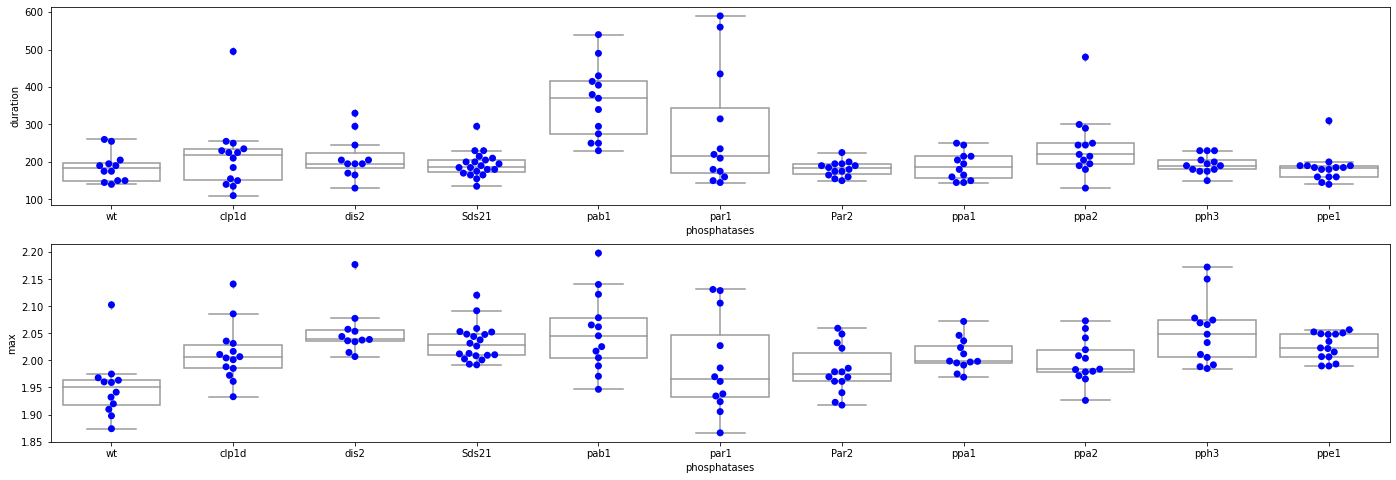

In [4]:
phoss = ["wt", "clp1d", "dis2", "Sds21", "pab1", "par1", "Par2", "ppa1", "ppa2", "pph3", "ppe1"]

fig, axes = plt.subplots(2, 1, figsize=(1*24, 2*4))
sns.swarmplot(x="phosphatases", y="duration", data=df_stats, ax=axes[0], color="blue", order=phoss, s=7)
sns.boxplot(x="phosphatases", y="duration", data=df_stats, ax=axes[0], color="white", order=phoss)

sns.swarmplot(x="phosphatases", y="max", data=df_stats, ax=axes[1], color="blue", order=phoss, s=7)
sns.boxplot(x="phosphatases", y="max", data=df_stats, ax=axes[1], color="white", order=phoss)

plt.savefig("./_phosphatases_duration-and-peak-value.png")
plt.savefig("./_phosphatases_duration-and-peak-value.pdf")


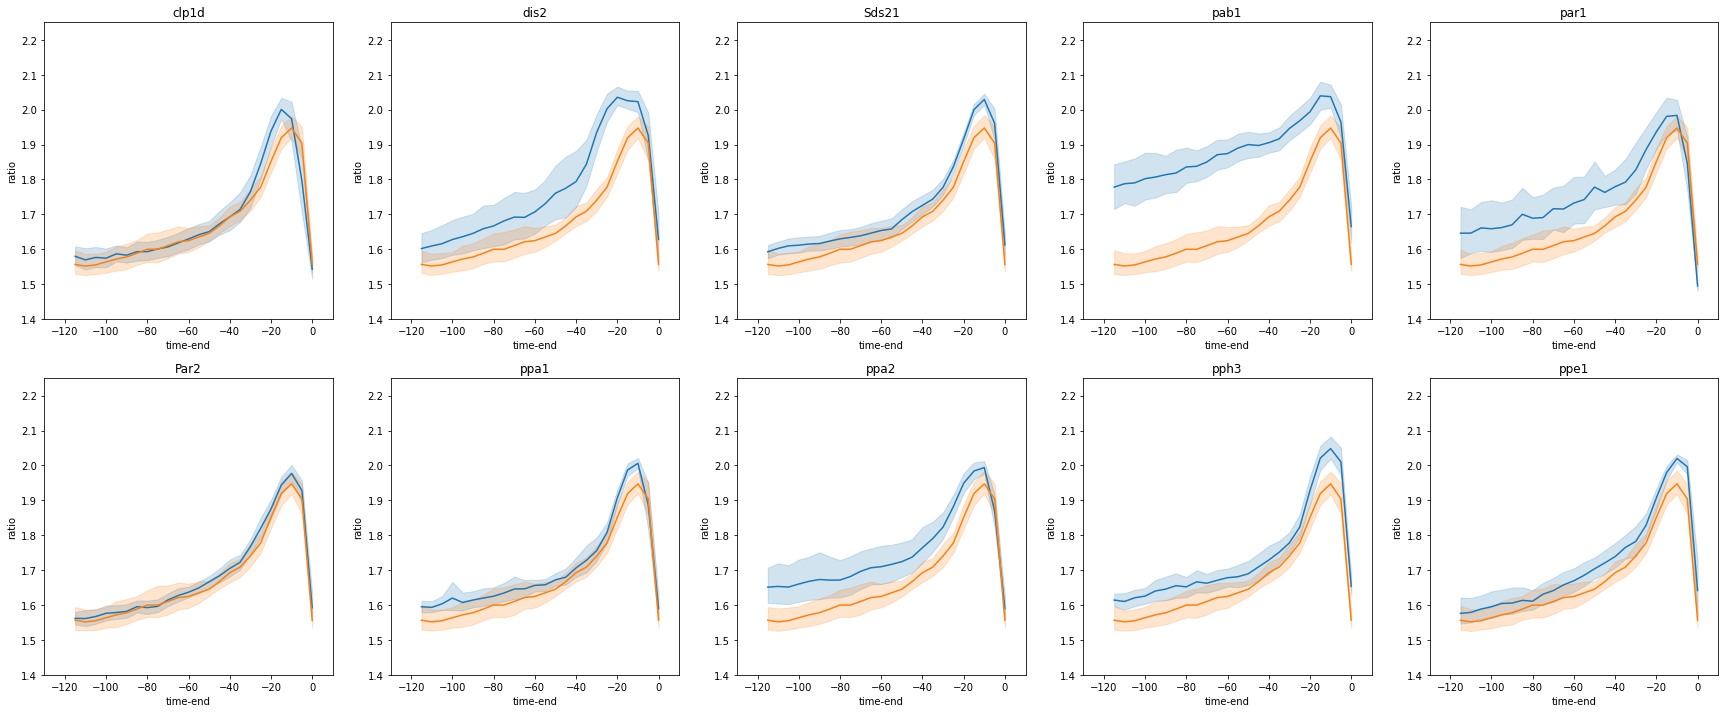

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(5*6, 2*6))
phoss = ["clp1d", "dis2", "Sds21", "pab1", "par1", "Par2", "ppa1", "ppa2", "pph3", "ppe1"]
for n, phos in enumerate(phoss):
    df_test = df_all.loc[(df_all["phosphatases"] == phos) & (df_all["time-end"] > -120)]  #分裂から１２０分までを抜き出す
    df_wt = df_all.loc[(df_all["phosphatases"] == "wt") & (df_all["time-end"] > -120)]  #分裂から１２０分までを抜き出す
    i = int(n / 5)
    j = int(n % 5)
    #sns.lineplot(x="time", y="ratio", data=df_test, ax=axes[i][j], ci=None, hue="cell ID", estimator=None)
    sns.lineplot(x="time-end", y="ratio", data=df_test, ax=axes[i][j], ci=95)
    sns.lineplot(x="time-end", y="ratio", data=df_wt, ax=axes[i][j], ci=95)
    axes[i][j].set_xlim(-130, 10)
    axes[i][j].set_ylim(1.4, 2.25)
    axes[i][j].set_title(phos)
plt.savefig("./_phosphatases_timecourse_aligned-by-end.png")
plt.savefig("./_phosphatases_timecourse_aligned-by-end.pdf")


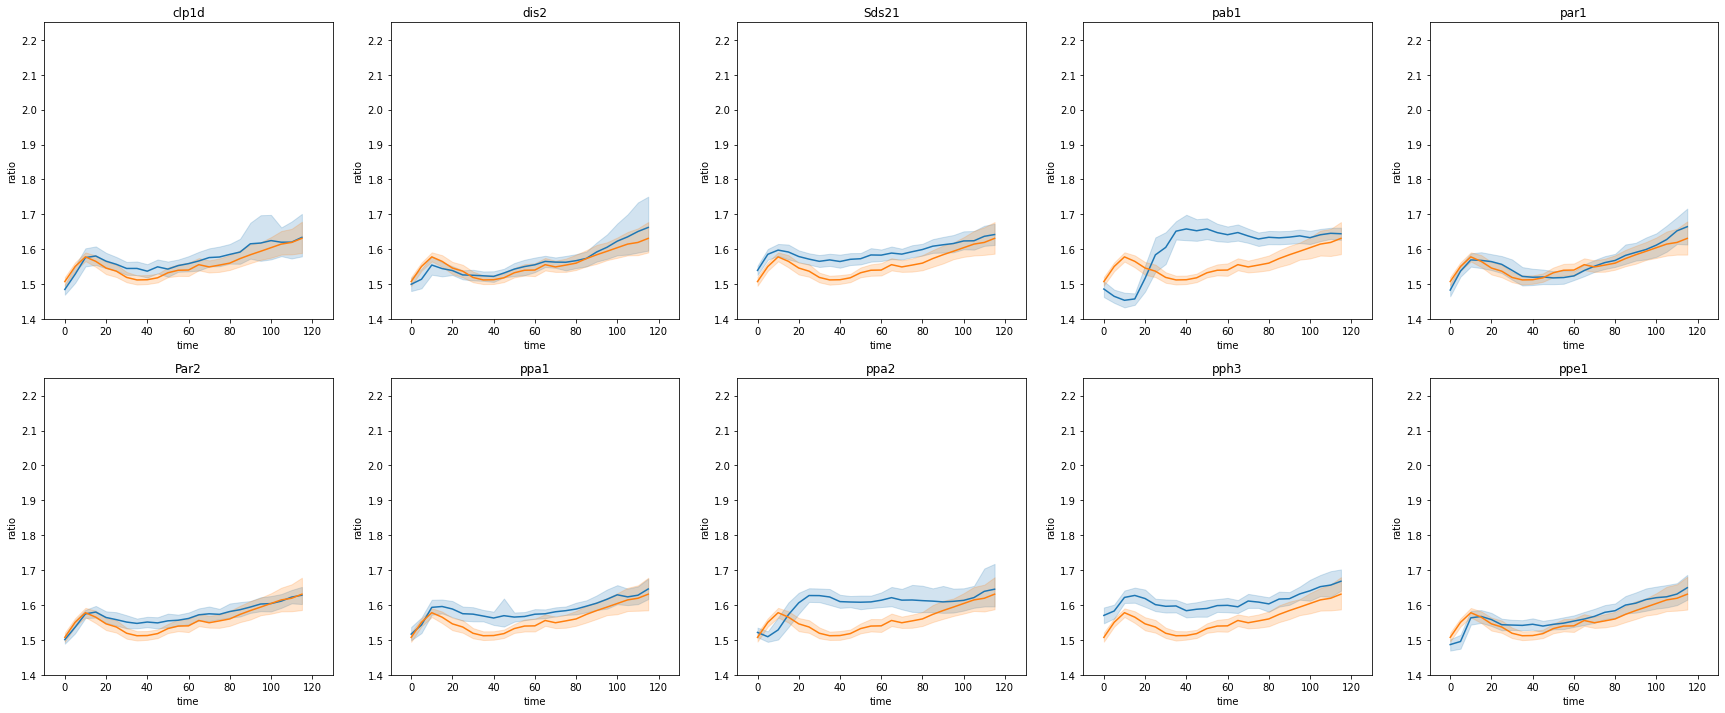

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(5*6, 2*6))
phoss = ["clp1d", "dis2", "Sds21", "pab1", "par1", "Par2", "ppa1", "ppa2", "pph3", "ppe1"]
for n, phos in enumerate(phoss):
    df_test = df_all.loc[(df_all["phosphatases"] == phos) & (df_all["time"] < 120)]  #分裂から１２０分までを抜き出す
    df_wt = df_all.loc[(df_all["phosphatases"] == "wt") & (df_all["time"] < 120)]  #分裂から１２０分までを抜き出す
    i = int(n / 5)
    j = int(n % 5)
    #sns.lineplot(x="time", y="ratio", data=df_test, ax=axes[i][j], ci=None, hue="cell ID", estimator=None)
    sns.lineplot(x="time", y="ratio", data=df_test, ax=axes[i][j], ci=95)
    sns.lineplot(x="time", y="ratio", data=df_wt, ax=axes[i][j], ci=95)
    axes[i][j].set_xlim(-10, 130)
    axes[i][j].set_ylim(1.4, 2.25)
    axes[i][j].set_title(phos)
plt.savefig("./_phosphatases_timecourse_aligned-by-start.png")
plt.savefig("./_phosphatases_timecourse_aligned-by-start.pdf")
